In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model

In [2]:
# Variables
MODEL = 'dense_mlp_model.keras'
SCALER = 'scalers.gz'
ENCODERS = 'encoders.gz'
CSV_FILE = 'dataset/mlfingerprint_data_unlabeld.csv'

In [3]:
# Load model, scaler, and label encoder
model = load_model(MODEL)
scalers = joblib.load(SCALER)
encoders = joblib.load(ENCODERS)

In [4]:
# Load unlabeled CSV file
df = pd.read_csv(CSV_FILE)

In [8]:
encoder = encoders['direction']
# Encode direction
encoded = encoder.transform(df[['direction']])
dir_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['direction']))
# Encode packetId
encoder = encoders['packetId']
encoded = encoder.transform(df[['packetId']])
packet_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['packetId']))

# Encode clientProtocolVersion
encoder = encoders['clientProtocolVersion']
encoded = encoder.transform(df[['clientProtocolVersion']])
client_protocol_version_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['clientProtocolVersion']))

# Concatenate all encoded DataFrames
encoded_df = pd.concat([dir_df, packet_df, client_protocol_version_df], axis='columns', ignore_index=True)
packet_df = pd.DataFrame(df['packetId'])


for packet_id in scalers['packet_ids']:
    scaler = scalers[packet_id]
    rows = (df['packetId'] == packet_id)
    if any(rows):
        packet_df.loc[rows, 'packet_length_norm'] = scaler.transform(df.loc[rows, ['length']])

scaler = scalers['iat']
encoded_df = pd.concat([encoded_df, packet_df['packet_length_norm']], axis='columns', ignore_index=False)
encoded_df['iat_norm'] =  scaler.transform(df[['iat']])

In [9]:
X_scaled = encoded_df.values  # Convert DataFrame to NumPy array
le = encoders['label']

In [10]:
# Calculate probabilities
y_proba = model.predict(X_scaled)  # shape = (n_samples, n_classes)
mean_probas = y_proba.mean(axis=0)  # average probability per class

labels = list(le.classes_)
sizes = mean_probas

755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


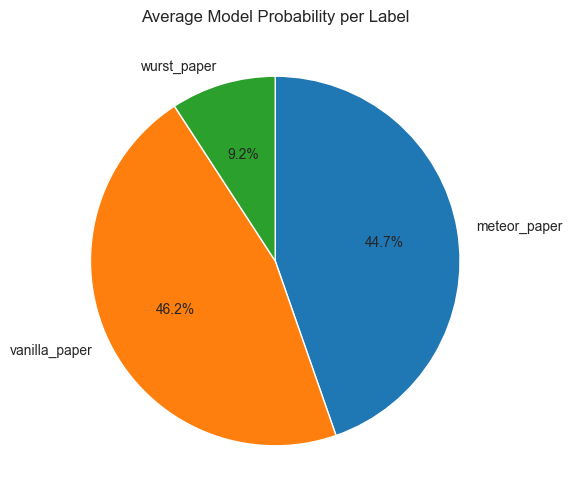

In [11]:
# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
ax.set_title("Average Model Probability per Label")
plt.show()